# Using seq2seq transformers for morphological inflexion: Arabic and it's "dialects"

*By Gabriel Pišvejc and Aeirya Mohammadi*

In this project, we train a number of seq2seq transformer models on different "dialects" of Arabic, using different amounts of training data. The main interest behind these experiments is that despite being called "dialects" the different varieties of Arabic are of often **not** mutually inteligible and sometimes even considered as different languages in linguistic circles.

We examine how this situation may impact training of Arabic inflexion models by testing models trained on one variety on both its own variety and a different one and observing the impact on performance. We also perform transfer learning to see how well are the models trained on one variety able to leverage the shared linguistic basis of the varieties to enhance learning efficiency and results.

## Setup

First things first, we will download the necessary libraries and load them in.

In [6]:
!wget https://raw.githubusercontent.com/mhulden/eztransformer/refs/heads/main/eztr.py
!mkdir downloads
!mv eztr.py downloads
## to clean up: rm downloads/eztr.py

#%pip install -r "../requirements.txt"
IS_COLAB = False
IS_MAC = True

device = "cuda" if IS_COLAB else "mps" if IS_MAC else "cpu"

--2026-01-03 22:35:57--  https://raw.githubusercontent.com/mhulden/eztransformer/refs/heads/main/eztr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17140 (17K) [text/plain]
Saving to: ‘eztr.py’

eztr.py             100%[===================>]  16.74K  --.-KB/s    in 0.007s  

2026-01-03 22:35:57 (2.35 MB/s) - ‘eztr.py’ saved [17140/17140]

mkdir: downloads: File exists


In [2]:
import matplotlib.pyplot as plt
from typing import Literal
from datasets import load_dataset
from downloads.eztr import EZTransformer

We will also define the functions used later in the analysis. We rely on the EZTransformer library to train the models, which is an implementation of PyTorch’s `transformer()` module provided by our professor.

EZTransformer provides a streamlined training interface via its `.fit` method. For the purposes of this project, we required access to training-time metrics in order to visualize learning curves and analyze performance across epochs. At the time of writing, this functionality was not included in the library, so we contributed a [Pull Request](https://github.com/mhulden/eztransformer/pull/1) to the library to record and return the training history. This change was merged upstream, so we make use of it in this notebook.

In [10]:
# Load the default data ########################################################

def load_data(
    lang: Literal['egyptian', 'gulf'],
    split: Literal['all', 'train', 'dev', 'no'] = 'all',
):
    lang = {'egyptian': 'arz', 'gulf': 'afb'}[lang]
    
    prefix = f"data/{lang}/{lang}"
    if IS_COLAB:
       prefix = '/content/' + prefix
    else:
       prefix = '../' + prefix
       
    files = {}
    if split in {"train", "all"}:
        files["train"] = f"{prefix}.trn"

    if split in {"train", "dev", "all", "no"}:
        files["dev"] = f"{prefix}.dev"

    if split in {"test", "all"}:
        files["test"] = f"{prefix}.tst"

    ds = load_dataset(
        'csv', delimiter="\t", data_files=files,
        column_names=["lemma", "features", "form"])

    if split == "no":
        return ds["dev"]

    return ds

# Aux function #################################################################

def process_split(split_data, batch_size: int = 100, num_proc: int = 4):
    # turn to characters
    split_data = split_data.map(
        lambda batch: {
            "lemma": [list(s) for s in batch["lemma"]],
            "form": [list(t) for t in batch["form"]],
            "features": [f.split(';') for f in batch["features"]],
        },
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
    )

    split_data = split_data.map(
        lambda batch: {
            'src': [l+f for l, f in zip(batch["lemma"], batch["features"])]
        },
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
        remove_columns=['features', 'lemma']
    )

    # only for compatibility with eztransformer's build_vocab
    split_data = split_data.map(
        lambda batch: {
            'src': [' '.join(item) for item in batch['src']],
            'form': [' '.join(item) for item in batch['form']],
        },
        batched=True,
        batch_size=batch_size,
        num_proc=num_proc,
    )
    return split_data

# Custom data loading ##########################################################

def load_partial(train_size: int,
                 dev_size: int,
                 test_size: int, # This test split is NOT being used downstream for now, but I am keeping it here for consistency
                 batch_size: int,
                 num_proc: int = 4,
                 lang='egyptian'):

    full_data_splits = load_data(lang=lang, split='all')

    processed_data = {}

    processed_data['train'] = full_data_splits['train'].select(range(0, train_size))

    processed_data['dev'] = full_data_splits['dev'].select(range(0, dev_size))

    processed_data['test'] = full_data_splits['test'].select(range(0, test_size))

    for split_name, split_dataset in processed_data.items():
      processed_data[split_name] = process_split(split_dataset, batch_size, num_proc)

    return processed_data

# Get a new model ##############################################################

def get_new_model():
  return EZTransformer(
    device = device,
    # learning rate
    lrt = 1e-3,
    # batch size
    bts = 256,
    # embedding
    eed = 256,
    ded = 256,
    # hidden size:
    ehs = 512,
    dhs = 512,
    # layers:
    enl = 2,
    dnl = 2,
    # heads:
    eah = 4,
    dah = 4,

    save_best = 10,

    # dropout
    drp=0.1
    )

# Model training ###############################################################

def ez_train(model, train_data, valid_data, epochs = 100, print_validation_examples = 0):
    if not isinstance(train_data, list):
        train_data = list(zip(train_data["src"], train_data["form"]))
        valid_data = list(zip(valid_data["src"], valid_data["form"]))

    # Train model
    history = model.fit(
        train_data = train_data,
        valid_data = valid_data,
        print_validation_examples = 0,
        max_epochs = epochs,
        return_history=True
        )

    model.print_validation_examples(valid_data, print_validation_examples)

    return history

# History analysis #############################################################

def training_history(history):

  min_epoch = history.loc[history["val_loss"].idxmin(), "epoch"]
  text = f"The lowest dev loss was reached in epoch {min_epoch}."

  plt.figure()
  plt.plot(history["epoch"], history["train_loss"], label="Train loss")
  plt.plot(history["epoch"], history["val_loss"], label="Dev loss")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Training and Dev loss")
  plt.legend()

  plt.show()
  print(text)


# Model testing ################################################################
def test_model(model, language):
  # Preprocess the data
  raw_test_data = load_data(lang=language, split="test")
  processed_test_data = process_split(raw_test_data["test"])

  test_inputs = processed_test_data["src"]
  test_targets = processed_test_data["form"]

  test_examples_for_printing = list(zip(processed_test_data['src'], processed_test_data['form']))

  # Use the default EZTF evaluation method
  model.score(test_inputs, test_targets)

  # Show examples
  model.print_validation_examples(test_examples_for_printing, 3)

# First experiment - Single variety trained models


## Egyptian Arabic

### Small training dataset

Having defined the functions, we can start by preparing the data for the training loop. We will pull 1000 training datapoints and another 100 datapoints to use as the dev split. In future experiments, we will also keep the dev split at 10% of the size of the train split.

In [11]:
data = load_partial(train_size=1000,
                    dev_size = 100,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

We will then use it to train the model.

In [ ]:
%%capture captured_output

egyptian1k = get_new_model()

history = ez_train(egyptian1k,
                   data['train'],
                   data['dev'],
                   epochs = 100)

KeyboardInterrupt: 

We can then take advantage of the newly added functionality and plot the training graphs which reveal that the loss improvement sharply decreased just after the 20th epoch, after which the model just started overfitting. It didn't necessarily cause a decrease in the dev performance, however, it subjected it to a degree of variance.

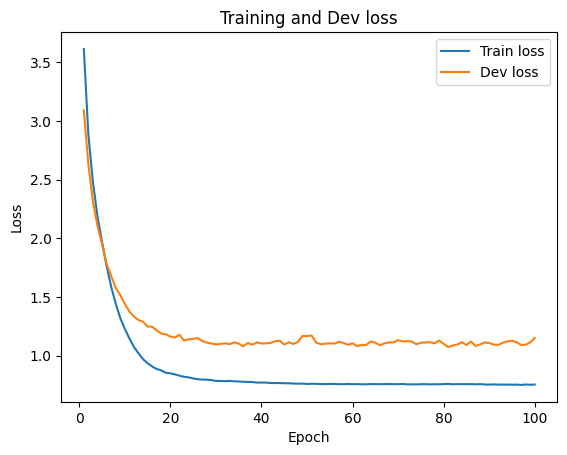

The lowest dev loss was reached in epoch 81.


In [ ]:
training_history(history)

As early stopping was not implemented, we just saved the best model based on the dev loss. We use it for evaluation on the test split, however, given the amount of training data, te performance is still quite low.

In [ ]:
test_model(egyptian1k, "egyptian")

Generating test split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Scoring: 100%|██████████| 16/16 [00:39<00:00,  2.44s/it]

Accuracy: 7.50%
Average Levenshtein Distance: 3.14

Validation Examples:
Input:     ن َ ق ّ ا ش N DEF MASC SG
Target:    ا ل ن ّ َ ق ّ ا ش
Predicted: ا ل ا ن ا ش ّ

Input:     ه َ د ّ ا ف N INDF MASC SG
Target:    ه َ د ّ ا ف
Predicted: أ َ ه ّ ا ف

Input:     م َ ق ا ل ِ ي ADJ DEF FEM SG
Target:    ا ل م َ ق ا ل ِ ي ّ َ ة
Predicted: ا ل م ق ِ ي ّ َ ة



On the Gulf set, we can see an even worse performance. What is noteworthy, however, is that the accuracy is still above zero, that is, some words in fact do get inflected correctly.

In [ ]:
test_model(egyptian1k, "gulf")

Generating test split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Scoring: 100%|██████████| 16/16 [00:36<00:00,  2.28s/it]

Accuracy: 0.40%
Average Levenshtein Distance: 4.00

Validation Examples:
Input:     ت َ ل ا ش َ ى V PFV NOM(MASC,SG,3)
Target:    ت ل ا ش ى
Predicted: أ َ ل َ ش ا ى

Input:     ن َ ب ض N INDF MASC SG
Target:    ن ب ض
Predicted: آ َ ب

Input:     ط ُ و ل N FEM SG PSSD
Target:    ط و ل ة
Predicted: آ ل َ ة



### Medium training dataset

For the medium dataset, we will do everything in a very similar fashion, except for the amount of data, which will naturally be bigger.

In [ ]:
%%capture captured_output

data = load_partial(train_size=5000,
                    dev_size = 500,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

egyptian5k = get_new_model()

history = ez_train(egyptian5k,
                   data['train'],
                   data['dev'],
                   epochs = 100)

In terms of loss evolution across epochs, we can notice that the same pattern repeats, except for the fact that the model starts overfitting even faster.

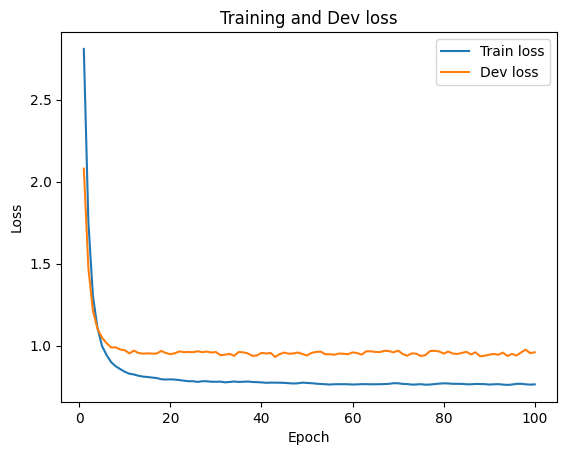

The lowest dev loss was reached in epoch 43.


In [ ]:
training_history(history)

Despite that, we can notice that the accuracy improves sharply on Egyptian Arabic:

In [ ]:
test_model(egyptian5k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:41<00:00,  2.57s/it]


Accuracy: 47.60%
Average Levenshtein Distance: 1.22

Validation Examples:
Input:     غ ُ ر ْ ز َ ة N FEM SG PSSD
Target:    غ ُ ر ْ ز َ ة
Predicted: ا ُ غ ْ ر َ ة

Input:     ا ِ ت ْ ن َ س َ ى V PFV NOM(MASC,SG,3)
Target:    ا ِ ت ْ ن َ س َ ى
Predicted: ا ِ ت ْ ن َ س َ ى

Input:     م َ ك ْ ت ُ و ب ADJ FEM SG PSSD
Target:    م َ ك ْ ت ُ و ب َ ة
Predicted: م َ ك ْ ت ُ و ب َ ة



We can however notice that the performance on Gulf Arabic is around where the previous model was on it's own variety.

In [ ]:
test_model(egyptian5k, "gulf")

Scoring: 100%|██████████| 16/16 [00:37<00:00,  2.35s/it]

Accuracy: 8.10%
Average Levenshtein Distance: 2.98

Validation Examples:
Input:     ط ا ب V PFV NOM(PL,1)
Target:    ط ِ ب ن ا
Predicted: ن ُ ب ُ و ا

Input:     ر َ أ س N MASC SG PSSD
Target:    ر أ س
Predicted: ر َ أ

Input:     ش ا ع ِ ر N MASC SG PSSD
Target:    ش ا ع ر
Predicted: ش ا ع ِ ر



### Large training dataset

We will once again repeat the pattern of training a new model but with more data. However, this time, we will also change the number of epochs. As the training is getting progressively longer and additional epochs have to shown to only introduce variance and overfitting, we will only train for 20 of them.

In [14]:
%%capture captured_output

data = load_partial(train_size=10000,
                    dev_size = 1000,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

egyptian10k = get_new_model()

history = ez_train(egyptian10k,
                   data['train'],
                   data['dev'],
                   epochs = 20)

In terms of loss evolution, as predicted, the overfitting sets in even quicker then before.

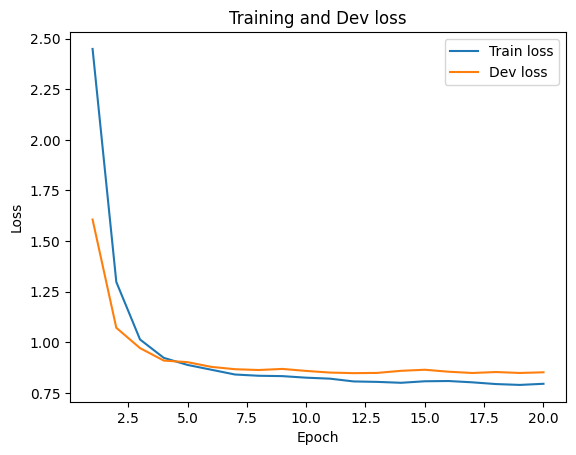

The lowest dev loss was reached in epoch 12.


In [15]:
training_history(history)

In terms of evaluation metrics, we once again observe a strong improvement on the model's own variety.

In [16]:
test_model(egyptian10k, "egyptian")

Generating test split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Scoring: 100%|██████████| 16/16 [12:15<00:00, 45.96s/it]


Accuracy: 86.70%
Average Levenshtein Distance: 0.26

Validation Examples:
Input:     ت َ ر ْ ق ِ ي م N DEF MASC SG
Target:    ا ل ت ّ َ ر ْ ق ِ ي م
Predicted: ا ل ت ّ َ ر ْ ق ِ ي م

Input:     م ُ ش ا ه ْ د َ ة N DEF FEM SG
Target:    ا ل م ُ ش ا ه ْ د َ ة
Predicted: ا ل م ُ ش ا ه ْ د َ ة

Input:     ا ِ ح ْ ت ِ ق ا ن N DEF MASC SG
Target:    ا ل ا ِ ح ْ ت ِ ق ا ن
Predicted: ا ل ا ِ ح ْ ت ِ ق ا ن



However, the model still finds it very hard to do inflexion on a different variety of Arabic.

In [17]:
test_model(egyptian10k, "gulf")

Generating test split: 0 examples [00:00, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

Scoring: 100%|██████████| 16/16 [11:03<00:00, 41.50s/it]


Accuracy: 10.30%
Average Levenshtein Distance: 2.54

Validation Examples:
Input:     ا ِ ك َ ّ ح ّ َ ل V IMP NOM(FEM,SG,2)
Target:    ا ك ح ل ي
Predicted: ا ِ ك َ ح ّ َ ل ِ ي

Input:     ا ِ ت ّ َ ج َ ه V PFV NOM(PL,3)
Target:    ا ِ ت ّ َ ج َ ه َ و ا
Predicted: ا ِ ت ّ َ ج ت َ ه ت

Input:     م ُ س ت َ ع ا ن ADJ DEF MASC SG
Target:    ا ل م س ت ع ا ن
Predicted: ا ل م ُ س ت َ ع ا ن



## Gulf Arabic

We will now examine the same process on a different variety. We will train on the Gulf variety and analyse performance on the model's "native" variety and then once again on Egyptian Arabic.

### Small training dataset

In [ ]:
%%capture captured_output

data = load_partial(train_size=1000,
                    dev_size = 100,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

gulf1k = get_new_model()

history = ez_train(gulf1k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

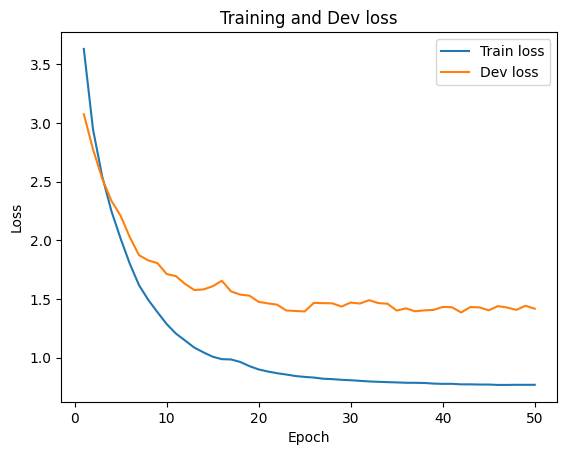

The lowest dev loss was reached in epoch 42.


In [ ]:
training_history(history)

We can see that the 1000 datapoints model shows notably worse results both on its own variety and on the other one, where it even reaches 0% accuracy, that is, no correctly inflected words whatsoever.

In [ ]:
test_model(gulf1k, "gulf")

Scoring: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]

Accuracy: 4.00%
Average Levenshtein Distance: 3.08

Validation Examples:
Input:     ت أ َ خ ّ َ ر V IPFV NOM(MASC,SG,2)
Target:    ت ِ ت أ َ خ ّ َ ر
Predicted: ت خ ر

Input:     ح َ د ّ َ د V IMP NOM(FEM,SG,2)
Target:    ح َ د ّ د ِ ي
Predicted: ح د ي

Input:     س َ ر َ ط - ُ ِ V IPFV NOM(MASC,SG,3)
Target:    ي س ر ط
Predicted: ي س ط ن



In [ ]:
test_model(gulf1k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it]

Accuracy: 0.00%
Average Levenshtein Distance: 5.04

Validation Examples:
Input:     م َ ل َ أ V PFV NOM(MASC,SG,3)
Target:    م َ ل َ أ
Predicted: ت م ل

Input:     ت َ ح ْ س ِ ي ن N INDF MASC SG
Target:    ت َ ح ْ س ِ ي ن
Predicted: ا ت ح س

Input:     ا ِ س ْ ت َ ع ْ م ِ ل V IPFV NOM(SG,1)
Target:    ا َ س ْ ت َ ع ْ م ِ ل
Predicted: ا س ت َ م ل ع



### Medium training dataset

In [ ]:
%%capture captured_output

data = load_partial(train_size=5000,
                    dev_size = 500,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

gulf5k = get_new_model()

history = ez_train(gulf5k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

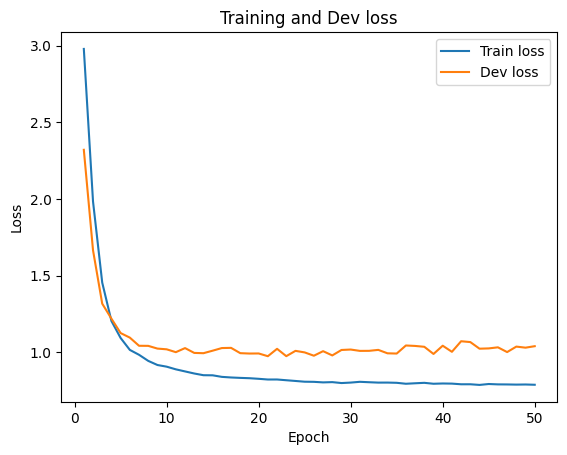

The lowest dev loss was reached in epoch 21.


In [ ]:
training_history(history)

Once again, we observe a sharp improvement in the evaluation metrics in the variety upon which the model trained upon and a small improvement in the second variety.

In [ ]:
test_model(gulf5k, "gulf")

Scoring: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]

Accuracy: 48.60%
Average Levenshtein Distance: 1.12

Validation Examples:
Input:     م ِ ح َ و ّ ِ ل ADJ INDF MASC SG
Target:    م ح و ل
Predicted: ت ح م و ل

Input:     ص َ غ ّ َ ر V IPFV NOM(FEM,SG,3)
Target:    ت ص َ غ ّ ِ ر
Predicted: ت غ َ ص ّ ِ ر

Input:     ك ِ ر ِ ي م ا N INDF FEM SG
Target:    ك ر ي م ا
Predicted: ر ك ي م ا م ة



In [ ]:
test_model(gulf5k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:29<00:00,  1.85s/it]

Accuracy: 3.20%
Average Levenshtein Distance: 3.54

Validation Examples:
Input:     ر َ ض َ ع V IPFV NOM(FEM,SG,3)
Target:    ت ِ ر ْ ض َ ع
Predicted: ت ِ ر ض ِ ع

Input:     ح َ ر َ ق V IPFV NOM(MASC,SG,2)
Target:    ت ِ ح ْ ر َ ق
Predicted: ت ِ ح ر ق ِ ق

Input:     ت َ ع ْ ر ِ ي ض N MASC SG PSSD
Target:    ت َ ع ْ ر ِ ي ض
Predicted: ت ع ر ي ا



### Large training dataset


In [ ]:
%%capture captured_output

data = load_partial(train_size=10000,
                    dev_size = 1000,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

gulf10k = get_new_model()

history = ez_train(gulf10k,
                   data['train'],
                   data['dev'],
                   epochs = 20)

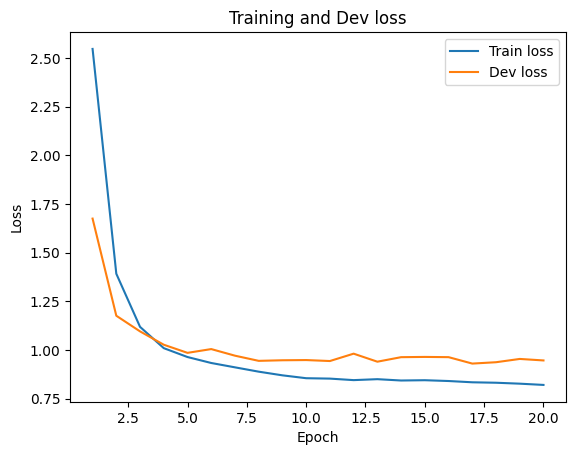

The lowest dev loss was reached in epoch 17.


In [ ]:
training_history(history)

And finally, we can once again see that the model is capable to generalise to a decent degree on its own variety, but struggles greatly with the other "dialect".

In [ ]:
test_model(gulf10k, "gulf")

Scoring: 100%|██████████| 16/16 [00:31<00:00,  1.98s/it]

Accuracy: 73.40%
Average Levenshtein Distance: 0.58

Validation Examples:
Input:     ح ا ب ِ ِ س ADJ MASC SG PSSD
Target:    ح ا ب س
Predicted: ح ا ب س

Input:     ع ا ج ِ ز ADJ INDF FEM SG
Target:    ع ا ج ز ة
Predicted: ع ا ج ز ة

Input:     ا َ ه ب َ ل ADJ INDF FEM SG
Target:    ه ب ل ة
Predicted: ا ه ب ل ى



In [ ]:
test_model(gulf10k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:29<00:00,  1.87s/it]

Accuracy: 4.50%
Average Levenshtein Distance: 3.04

Validation Examples:
Input:     ل ِ ب ا س N DEF MASC SG
Target:    ا ل ل ّ ِ ب ا س
Predicted: ا ل ل ب ا س

Input:     ع ِ ن ْ و ا ن N DEF MASC PL
Target:    ا ل ع َ ن ا و ِ ي ن
Predicted: ا ل ع ن و ن ا ت

Input:     ا ِ ر ا د َ ة N INDF FEM SG
Target:    ا ِ ر ا د َ ة
Predicted: ا ر ا د ة



## Conclusions - Single variety trained models

In this experiment, we have shown the problems transformers have in terms of generalisation between different Arabic "dialects". This can be largely explained by theoretical linguistics. While this is by no means an exhaustive explanation, we can take a look at the different morphological patterns in both varieties. For example, the verbal conjugations of the verb يعمل (to work) in present plural.

| Morphology | Egyptian                 | Gulf                    |
| ---------- | ------------------------ | ----------------------- |
| 1.p. pl.   | نِعْمِل - /niʕmil/       | نِعمِل - /niʕmil/       |
| 2.p. pl.   | تِعْمِلُوا - /tiʕmiluwa/ | تِعمُلُون - /tiʕmuluwn/ |
| 3.p. pl.   | يِعْمِلُوا - /jiʕmiluwa/ | يِعمُلُون - /jiʕmuluwn/ |

We can see that the morphemes used to form the second and third person are not shared across varieties. Similar phenomena take place in essentially all morphological paradigms. Another factor complicating the task at hand is that not all morphological categories are shared between the varieties. An example of this would be the absence of the dual number in Egyptian verbs.



# Second experiment - Transfer learning

In this experiment, we will try to take the models we previously trained on large quantities of data: `gulf10k` & `egyptian10k` and use their weights and biases as a starting point for training on the new variety. As the architecture used in the networks is quite simple, no layers will be frozen, allowing the models to completely adapt to the new variety.


In [18]:
# used for creating deep copies of models before further fine-tuning
import copy

## Gulf Arabic


### Small training dataset

We will start by taking the `egyptian10k` model and fine-tuning it for Gulf Arabic.


In [19]:
%%capture captured_output

data = load_partial(train_size=1000,
                    dev_size = 100,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

egyptian10kgulf1k = copy.deepcopy(egyptian10k)

history = ez_train(egyptian10kgulf1k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

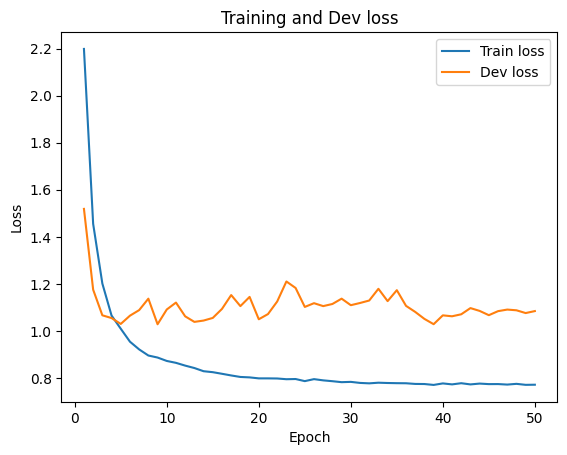

The lowest dev loss was reached in epoch 9.


In [20]:
training_history(history)

We can immediately see an improvement in the results. In terms of accuracy, the original model trained on 1000 Gulf Arabic examples reached 4% on the Gulf test split and 0% on the Egyptian one. The new model more then quadrupled the performance on the Gulf variety and managed to get at least a few correct guesses on the Egyptian variety. We should also note that the starting point of this model before the fine-tuning reached 85.30% accuracy on the Egyptian test split, therefore, this method of fine-tuning, while beneficial for the new task at hand, completely ruins the performance on the original task.

In [21]:
test_model(egyptian10kgulf1k, "gulf")

Scoring: 100%|██████████| 16/16 [08:02<00:00, 30.17s/it]


Accuracy: 10.60%
Average Levenshtein Distance: 2.31

Validation Examples:
Input:     ر ِ ض ا ء N MASC SG PSSD
Target:    ر ض ا ء
Predicted: ا ر ا ء

Input:     ا ِ م ت َ ح َ ن V IPFV NOM(MASC,SG,3)
Target:    ي ِ م ت ِ ح ِ ن
Predicted: ي م ت ح م ن

Input:     ط ُ و ل N MASC SG PSSD
Target:    ط و ل
Predicted: ط ل



In [22]:
test_model(egyptian10kgulf1k, "egyptian")

Scoring: 100%|██████████| 16/16 [08:10<00:00, 30.65s/it]


Accuracy: 0.00%
Average Levenshtein Distance: 4.24

Validation Examples:
Input:     م ُ و ا ف ِ ق N MASC SG PSSD
Target:    م ُ و ا ف ِ ق
Predicted: ا م ا ف

Input:     ك َ ل ا م N MASC SG PSSD
Target:    ك َ ل ا م
Predicted: ا ك ا م

Input:     ح ُ ر ْ ق َ ة N INDF FEM SG
Target:    ح ُ ر ْ ق َ ة
Predicted: ح ر و ق ة



### Medium training dataset

In [ ]:
%%capture captured_output

data = load_partial(train_size=5000,
                    dev_size = 500,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

egyptian10kgulf5k = copy.deepcopy(egyptian10k)

history = ez_train(egyptian10kgulf5k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

We can notice that with the medium sized testing dataset (5000 datapoints), the overfitting sets in quicker then in the previous models and starts actively worsening the performance on the dev split, instead of just introducing variance.  

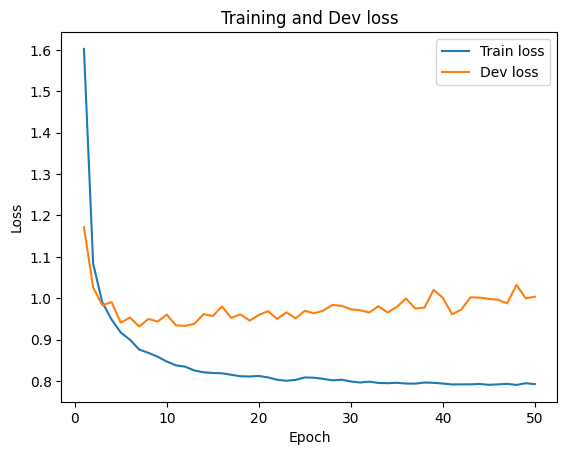

The lowest dev loss was reached in epoch 7.


In [24]:
training_history(history)

In terms of accuracy, we can still see a slight improvement on the Gulf variety of about ~10% over the original `gulf5k` model.

The improvements on the Egyptian variety are, however, less than 1%. We could speculate that this is in fact no improvement at all, however we can not give a solid proof as we lack the hardware for generating a proper Monte-Carlo estimation confidence interval. (Running this notebook as is already exhausted Gabriel's Google Colab GPU limit...)

In [25]:
test_model(egyptian10kgulf5k, "gulf")

Scoring: 100%|██████████| 16/16 [09:21<00:00, 35.12s/it]


Accuracy: 61.40%
Average Levenshtein Distance: 0.79

Validation Examples:
Input:     خ َ ي م َ ة N DEF FEM SG
Target:    ا ل خ ي م ة
Predicted: ا ل خ ي م ة

Input:     ا ِ ن غ َ ر َ س V IPFV NOM(MASC,SG,3)
Target:    ي ن غ ر س
Predicted: ي ن غ ر س

Input:     ب َ ي ّ َ ض V IPFV NOM(FEM,SG,3)
Target:    ت ب َ ي ّ ِ ض
Predicted: ت ب َ ي ّ ِ ض



In [26]:
test_model(egyptian10kgulf5k, "egyptian")

Scoring: 100%|██████████| 16/16 [08:42<00:00, 32.66s/it]


Accuracy: 3.70%
Average Levenshtein Distance: 3.12

Validation Examples:
Input:     ت َ ظ ا ه ُ ر َ ة N FEM SG PSSD
Target:    ت َ ظ ا ه ُ ر َ ة
Predicted: ت ظ ا ه ة

Input:     س َ ع َ د V IPFV NOM(FEM,SG,3)
Target:    ت ِ س ْ ع َ د
Predicted: ت ِ س ع َ د

Input:     ر َ ز َ ق V PFV NOM(MASC,SG,3)
Target:    ر َ ز َ ق
Predicted: ر َ ز َ ق



### Large training dataset

In [27]:
%%capture captured_output

data = load_partial(train_size=10000,
                    dev_size = 1000,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "gulf")

egyptian10kgulf10k = copy.deepcopy(egyptian10k)

history = ez_train(egyptian10kgulf10k,
                   data['train'],
                   data['dev'],
                   epochs = 20)

We can once again see the same pattern repeating: Overfitting sets in even faster and starts actively worsening the models performance.

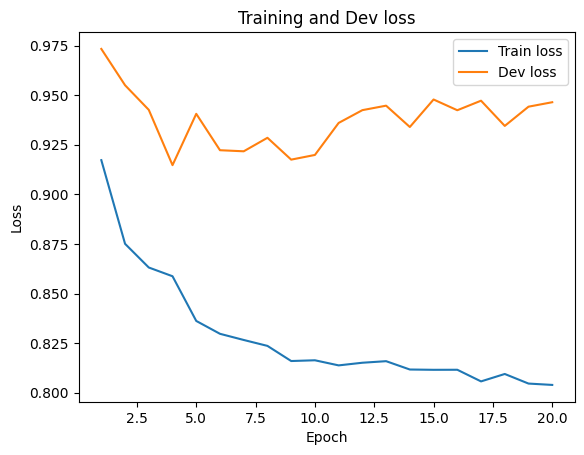

The lowest dev loss was reached in epoch 4.


In [ ]:
training_history(history)

In terms of accuracy on the Gulf variety, te model actually performs worse then the original `gulf10k` model by about 1%. We can once again speculate whether there is a statistically significant pattern, however, we cannot prove anything.

Regarding the Egyptian variety, the accuracy is exactly the same as the original `gulf10k` model's.

In [28]:
test_model(egyptian10kgulf10k, "gulf")

Scoring: 100%|██████████| 16/16 [08:56<00:00, 33.55s/it]


Accuracy: 73.80%
Average Levenshtein Distance: 0.49

Validation Examples:
Input:     خ َ ي م َ ة N INDF FEM DU
Target:    خ ي م ت ي ن
Predicted: خ ي م ت ي ن

Input:     ب ِ غ ِ ي V PFV NOM(MASC,SG,3)
Target:    ب غ ي ت ي
Predicted: ب غ

Input:     ا ِ ح ص ا ئ ِ ي ّ َ ة N INDF FEM PL
Target:    ا ح ص ا ئ ي ا ت
Predicted: ا ح ص ا ئ ي ا ت



In [29]:
test_model(egyptian10kgulf10k, "egyptian")

Scoring: 100%|██████████| 16/16 [08:20<00:00, 31.27s/it]


Accuracy: 4.50%
Average Levenshtein Distance: 2.88

Validation Examples:
Input:     م ُ و س ِ ي ق َ ى N INDF MASC SG
Target:    م ُ و س ِ ي ق َ ى
Predicted: م و س ي ق ى

Input:     ا ِ ت ْ ح َ ر ّ َ ك V PFV NOM(MASC,SG,3)
Target:    ا ِ ت ْ ح َ ر ّ َ ك
Predicted: ا ت ح ر ك

Input:     ت َ ظ ا ه ُ ر َ ة N DEF FEM SG
Target:    ا ل ت َ ظ ا ه ُ ر َ ة
Predicted: ا ل ت ظ ا ه ا ر ة



## Egyptian Arabic

### Small training dataset

For one final time, we will switch varieties. This time, we will fine-tune the `gulf10k` model for Egyptian Arabic inflexion.

In [30]:
%%capture captured_output

data = load_partial(train_size=1000,
                    dev_size = 100,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

gulf10kegyptian1k = copy.deepcopy(gulf10k)

history = ez_train(gulf10kegyptian1k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

NameError: name 'gulf10k' is not defined

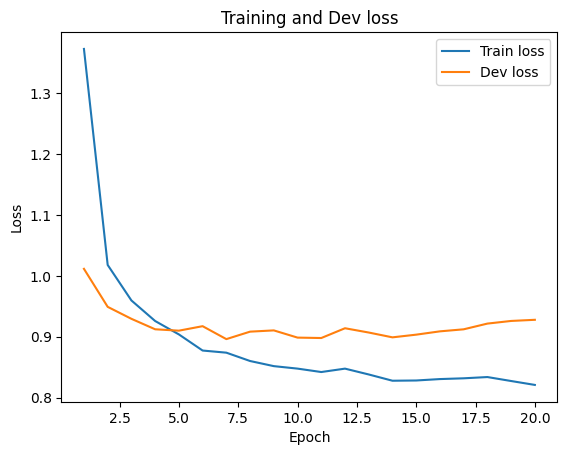

The lowest dev loss was reached in epoch 7.


In [31]:
training_history(history)

In terms of accuracy, the original `egyptian1k` model reached 7.5% on its own variety and 0.4% on the Gulf variety. We can see large improvements on both Arabics in the fine-tuned model, however, once again, the fine-tuning has a strong and negative impact on the original task, where the `gulf10k` model reached 73.4% accuracy.

In [32]:
test_model(gulf10kegyptian1k, "egyptian")

NameError: name 'gulf10kegyptian1k' is not defined

In [ ]:
test_model(gulf10kegyptian1k, "gulf")

Scoring: 100%|██████████| 16/16 [00:38<00:00,  2.40s/it]

Accuracy: 16.80%
Average Levenshtein Distance: 2.06

Validation Examples:
Input:     ك ِ ي ر م N DEF MASC SG
Target:    ا ل ك ي ر م
Predicted: ا ل ك ُ ر

Input:     ا ِ ف ت َ ر ّ V IMP NOM(MASC,SG,2)
Target:    ا ِ ف ت َ ر ّ
Predicted: ا ِ ف ت َ ر ّ

Input:     ه َ ي م ا ن ADJ MASC SG PSSD
Target:    ه ي م ا ن
Predicted: ه َ ي م ا ن



### Medium training dataset

In [ ]:
%%capture captured_output

data = load_partial(train_size=5000,
                    dev_size = 500,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

gulf10kegyptian5k = copy.deepcopy(gulf10k)

history = ez_train(gulf10kegyptian5k,
                   data['train'],
                   data['dev'],
                   epochs = 50)

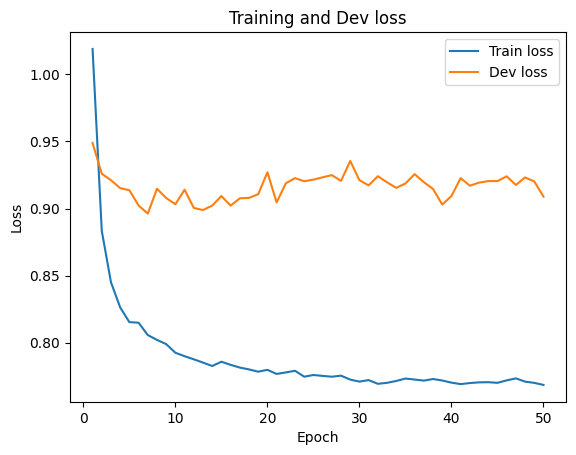

The lowest dev loss was reached in epoch 7.


In [ ]:
training_history(history)

We can see a very noticeable improvement on the medium dataset, as the original `egyptian5k` model only reached 47% accuracy on its own variety.

We can however also see that the performance on the Gulf variety is decreasing in comparison to the previous fine-tuned model, however, still being higher then any of the original Egyptian-only models.

In [ ]:
test_model(gulf10kegyptian5k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:42<00:00,  2.65s/it]


Accuracy: 79.20%
Average Levenshtein Distance: 0.40

Validation Examples:
Input:     ت َ ع ْ ر ِ ي ض N DEF MASC SG
Target:    ا ل ت ّ َ ع ْ ر ِ ي ض
Predicted: ا ل ت ّ َ ع ْ ر ِ ي ض

Input:     ت ِ ر ْ س ا ن َ ة N INDF FEM SG
Target:    ت ِ ر ْ س ا ن َ ة
Predicted: ت ِ ر ْ س ا ن َ ة

Input:     م َ ف ْ ت ُ و ح ADJ DEF MASC SG
Target:    ا ل م َ ف ْ ت ُ و ح
Predicted: ا ل م ّ َ ف ْ ت ُ و ح



In [ ]:
test_model(gulf10kegyptian5k, "gulf")

Scoring: 100%|██████████| 16/16 [00:39<00:00,  2.45s/it]

Accuracy: 12.60%
Average Levenshtein Distance: 2.34

Validation Examples:
Input:     ا ِ ن ش َ ق ّ V IPFV NOM(MASC,SG,2)
Target:    ت ِ ن ش َ ق ّ
Predicted: ت ِ ن ش َ ق ّ

Input:     ش ا ع ِ ر N DEF MASC SG
Target:    ا ل ش ا ع ر
Predicted: ا ل ش ّ ا ع ِ ر

Input:     ا َ ج ّ َ ر V IPFV NOM(PL,1)
Target:    ا ج ر
Predicted: ن ِ ا ج ّ َ ر



### Large training dataset

In [ ]:
%%capture captured_output

data = load_partial(train_size=10000,
                    dev_size = 1000,
                    test_size = 0,
                    batch_size = 100,
                    num_proc= 4,
                    lang = "egyptian")

gulf10kegyptian10k = copy.deepcopy(gulf10k)

history = ez_train(gulf10kegyptian10k,
                   data['train'],
                   data['dev'],
                   epochs = 20)

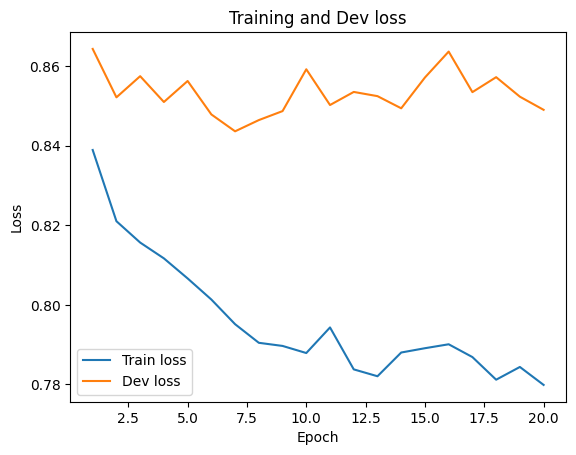

The lowest dev loss was reached in epoch 7.


In [ ]:
training_history(history)

Fine-tuning on the large dataset, the model reaches better accuracy on the Egyptian training split then the original `egyptian10k` model, however, only by 1%, once again inviting the question of whether this is a consistent pattern, or just a one-of.

In terms of accuracy on the Gulf variety, it is better then the original Egyptian-only model, yet still worse then the model finetuned on only 1000 Egyptian datapoints.

In [ ]:
test_model(gulf10kegyptian10k, "egyptian")

Scoring: 100%|██████████| 16/16 [00:41<00:00,  2.61s/it]

Accuracy: 86.30%
Average Levenshtein Distance: 0.27

Validation Examples:
Input:     ا ِ ت ْ ج َ س ّ ِ س V PFV NOM(MASC,SG,3)
Target:    ا ِ ت ْ ج َ س ّ ِ س
Predicted: ا ِ ت ْ ج َ س ّ ِ س

Input:     ع َ ز َ م V IPFV NOM(PL,1)
Target:    ن ِ ع ْ ز ِ م
Predicted: ن ِ ع ْ ز ِ م

Input:     ت َ ح ْ ر ِ ي ك N INDF MASC SG
Target:    ت َ ح ْ ر ِ ي ك
Predicted: ت َ ح ْ ر ِ ي ك



In [ ]:
test_model(gulf10kegyptian10k, "gulf")

Scoring: 100%|██████████| 16/16 [00:39<00:00,  2.50s/it]

Accuracy: 12.90%
Average Levenshtein Distance: 2.31

Validation Examples:
Input:     ا َ ن ّ َ ب V PFV NOM(MASC,SG,3)
Target:    ا ن ب
Predicted: أ َ ن ّ َ ب

Input:     ا َ م ا ن N MASC SG PSSD
Target:    ا م ا ن
Predicted: أ َ م ا ن

Input:     ع َ ش ّ َ ى V PFV NOM(FEM,SG,3)
Target:    ع َ ش ّ َ ت
Predicted: ع َ ش ّ ِ ت



## Conclusions - Transfer learning

Our experiments seem to indicate that transfer learning can be beneficial for inflexion models operating on the Arabic varieties.

We observed that the models fine-tuned on smaller or medium datasets are capable of generalising the knowledge acquired on one variety to another, showing a consistent improvement in accuracy, however, models trained on large quantities of data seem to be indifferent to the pre-training.

All models seem to benefit from pre-training in terms of the number of epochs required to converge into a loss function minimum.

While not fully explored in this notebook, the pre-trained models seem to be more susceptible to overfitting while training for too many epochs on the new variety.